# Reducing NBA Injuries

### Author: [Richard Hinds](https://github.com/RH3421)

## Background

Season ending injuries are some of the most devastating for NBA players. Not even a decade ago most of these injuries, including ACL and Achilles tendon ruptures, were nearly always career-ending. While medical technology has advanced since then, season-ending injuries are still extremely distressing for players, front office staff, and fans. Given the physical, emotional, and financial toll of these injuries, I sought to quantify risk factors and develop a model to identify NBA players at high risk for season-ending injuries.

## Data Understanding

Using a NBA injury dataset from Kaggle with more than 17,000 entries over 9 seasons and the NBA player stats, I created a combined dataset which links prior season stats with current season risk of season-ending injury. The hope is that such a model may be used to identify at-risk players so that their activity can be modified to reduce risk of injury. This would benefit both NBA players and other stakeholders.

## EDA and Data Cleaning

In [1]:
# Import libraries
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import numpy as np
import gzip as gz
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=(RuntimeWarning))
import itertools 
from zipfile import ZipFile
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, plot_roc_curve, plot_confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from collections import Counter
from statsmodels.api import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

In [2]:
# Load and explore dataset
nba = 'Data/NBAInjuries.zip'
with ZipFile(nba, 'r') as zip:
    zip.extractall('nba_unzipped')
    
df = pd.read_csv('Data/nba_unzipped/injuries_2010-2020.csv')
df

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out indefinitely)
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out indefinitely)
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)
...,...,...,...,...,...
27100,2020-09-30,Lakers,Dion Waiters,NaN,activated from IL
27101,2020-10-02,Heat,NaN,Bam Adebayo,strained neck (DTD)
27102,2020-10-02,Heat,NaN,Goran Dragic,placed on IL with torn plantar fascia in left foot
27103,2020-10-02,Heat,Chris Silva,NaN,activated from IL


In [3]:
# Drop Acquired column, null values, and rename Relinquished to Name
df.drop(['Acquired'], axis=1, inplace=True)
df.dropna(inplace=True)
df.rename(columns={'Relinquished':'Name'}, inplace=True)
df.head()

,Date,Team,Name,Notes
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger (out indefinitely)
1,2010-10-06,Pistons,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot (out indefinitely)
3,2010-10-08,Blazers,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,Troy Murphy,strained lower back (out indefinitely)


In [4]:
# Check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17558 entries, 0 to 27102
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    17558 non-null  object
 1   Team    17558 non-null  object
 2   Name    17558 non-null  object
 3   Notes   17558 non-null  object
dtypes: object(4)
memory usage: 685.9+ KB


In [5]:
# Create series of Notes column
s1 = df.Notes

In [6]:
# Quantify season ending injuries 
out_for_season = s1.str.contains('out for season', case=False)
out_for_season.value_counts()

False    16433
True      1125
Name: Notes, dtype: int64

In [7]:
# Binary label out_of_season as target
df = df.assign(out_for_season=pd.Series(out_for_season).values)
df = df*1

# Dataset of injuries that resulted in player being 'out for season'
ofs = df[(df['Notes'].str.contains('out for season', case=False))]
ofs.head()

,Date,Team,Name,Notes,out_for_season
8,2010-10-12,Bucks,Darington Hobson,surgery on left hip (out for season),1
17,2010-10-26,Blazers,Greg Oden,placed on IL with left knee injury (out for season),1
75,2010-10-27,Pistons,Jonas Jerebko,placed on IL recovering from surgery to repair torn right Achilles tendon (out for season),1
76,2010-10-27,Pistons,Terrico White,placed on IL recovering from surgery on right foot to repair broken fifth metatarsal (out for season),1
175,2010-11-04,Blazers,Elliot Williams,"dislocated patella in right knee (surgery, out for season)",1


In [8]:
# Split injury data by season
ofs_10 = ofs[(ofs['Date'] < '2011-07-01')]
ofs_11 = ofs[(ofs['Date'].between('2011-07-01','2012-07-01'))]
ofs_12 = ofs[(ofs['Date'].between('2012-07-01','2013-07-01'))]
ofs_13 = ofs[(ofs['Date'].between('2013-07-01','2014-07-01'))]
ofs_14 = ofs[(ofs['Date'].between('2014-07-01','2015-07-01'))]
ofs_15 = ofs[(ofs['Date'].between('2015-07-01','2016-07-01'))]
ofs_16 = ofs[(ofs['Date'].between('2016-07-01','2017-07-01'))]
ofs_17 = ofs[(ofs['Date'].between('2017-07-01','2018-07-01'))]
ofs_18 = ofs[(ofs['Date'].between('2018-07-01','2019-07-01'))]

Multiple entries for same player and injury are noted. The duplicates need to be removed.

In [9]:
# Function to drop duplicates
def DropDuplicates(dataset):
    return dataset.drop_duplicates(subset=['Name'], inplace=True)

# Make list of season datasets
list_ofs = [ofs_10, ofs_11, ofs_12, ofs_13, ofs_14, ofs_15,
            ofs_16, ofs_17, ofs_18]

# Apply function
[DropDuplicates(season) for season in list_ofs]

<ipython-input-9-b83b864be86c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return dataset.drop_duplicates(subset=['Name'], inplace=True)


[None, None, None, None, None, None, None, None, None]

Import NBA player stats

In [10]:
# Import player stats
p09 = pd.read_excel('Data/player_stats/2009-2010.xlsx')
p10 = pd.read_excel('Data/player_stats/2010-2011.xlsx')
p11 = pd.read_excel('Data/player_stats/2011-2012.xlsx')
p12 = pd.read_excel('Data/player_stats/2012-2013.xlsx')
p13 = pd.read_excel('Data/player_stats/2013-2014.xlsx')
p14 = pd.read_excel('Data/player_stats/2014-2015.xlsx')
p15 = pd.read_excel('Data/player_stats/2015-2016.xlsx')
p16 = pd.read_excel('Data/player_stats/2016-2017.xlsx')
p17 = pd.read_excel('Data/player_stats/2017-2018.xlsx')

# Read dummy 2018 data for chart
p18 = pd.read_excel('Data/player_stats/2018-2019.xlsx')

# Make list of season datasets
list_p = [p10, p11, p12, p13, p14,
            p15, p16, p17, p18]

In [11]:
# Merge stats dataset with injury dataset
s09 = pd.merge(p09,ofs_10, how='left', on='Name')
s10 = pd.merge(p10,ofs_11, how='left', on='Name')
s11 = pd.merge(p11,ofs_12, how='left', on='Name')
s12 = pd.merge(p12,ofs_13, how='left', on='Name')
s13 = pd.merge(p13,ofs_14, how='left', on='Name')
s14 = pd.merge(p14,ofs_15, how='left', on='Name')
s15 = pd.merge(p15,ofs_16, how='left', on='Name')
s16 = pd.merge(p16,ofs_17, how='left', on='Name')
s17 = pd.merge(p17,ofs_18, how='left', on='Name')

Now let us build a chart to visualize the incidence of season ending injury in the NBA by season

In [12]:
# For loop calculating injury incidence
inj_incidence=[]
for inj,p in itertools.zip_longest(list_ofs,list_p):
    inj_incidence.append(len(inj.index)/len(p.index))

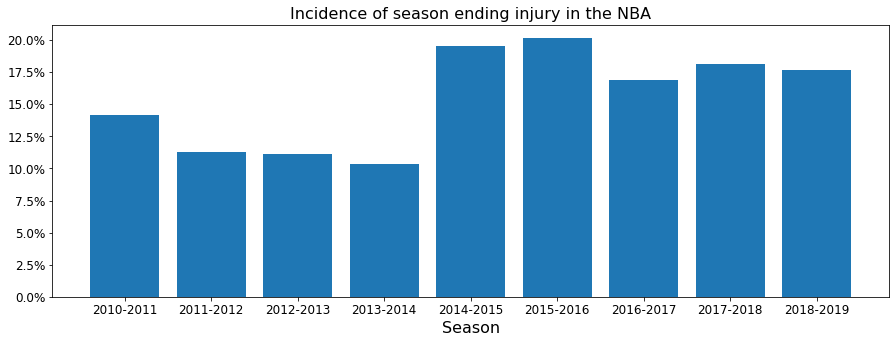

In [13]:
# Build chart
x=['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019']
y=inj_incidence
fig, ax = plt.subplots(figsize=(15,5))
bars = ax.bar(x,y)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel('Season', size=16)
ax.set_title('Incidence of season ending injury in the NBA', size=16);

In [14]:
# Concatenate season datasets into main dataset
df_con = pd.concat([s09,s10,s11,s12,s13,s14,s15,s16,s17], axis=0)
df_con.head()

,Name,TEAM,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT YEAR,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Date,Team,Notes,out_for_season
0,Aaron Brooks,HOU,25,6-1,161,Oregon,USA,2007,1,26,82,0.2,0.549,42,40,35.6,19.6,7.0,16.2,43.2,2.5,6.4,39.8,3.0,3.6,82.2,0.7,2.0,2.6,5.3,2.8,0.8,0.2,2.4,30.9,6,0,-0.3,2919,25.4,25.1,26.2,41.5,37.8,22.5,21.1,8.1,8.8,8.6,32.7,27.0,16.2,6.2,21.3,16.3,19.7,26.0,NaN,NaN,NaN,NaN
1,Aaron Gray,NOH,25,7-1,270,Pittsburgh,USA,2007,2,49,32,-3.1,0.551,11,21,9.7,3.3,1.3,2.6,51.2,0.0,0.0,0.0,0.6,0.9,71.4,1.4,1.9,3.3,0.7,0.6,0.3,0.3,1.7,9.6,0,0,-0.4,311,16.0,17.2,15.4,0.0,0.0,21.5,23.1,52.3,30.8,37.3,16.5,18.0,18.0,35.5,25.0,37.5,18.5,16.9,NaN,NaN,NaN,NaN
2,Acie Law,CHI,25,6-3,202,Texas A&M,USA,2007,1,11,26,5.3,0.585,11,15,9.0,4.3,1.3,2.9,46.7,0.2,0.6,31.3,1.5,1.9,77.6,0.1,0.5,0.7,1.0,0.7,0.4,0.0,0.6,7.4,0,0,0.8,234,21.4,18.6,19.4,14.7,18.4,29.9,30.4,6.1,10.3,9.2,26.0,29.8,24.4,4.2,39.4,14.0,27.8,21.0,2011-03-29,Warriors,placed on IL with right wrist injury (out for season),1.0
3,Adam Morrison,LAL,25,6-8,205,Gonzaga,USA,2006,1,3,31,-8.3,0.418,23,8,7.8,2.4,1.0,2.7,37.6,0.2,0.7,23.8,0.2,0.3,62.5,0.3,0.7,1.0,0.6,0.3,0.1,0.1,0.5,4.7,0,0,-1.2,241,17.8,17.7,20.1,13.9,21.2,6.8,7.7,16.4,13.6,14.3,16.8,13.9,10.0,8.0,30.0,20.2,5.8,15.7,NaN,NaN,NaN,NaN
4,AJ Price,IND,23,6-2,181,Connecticut,USA,2009,2,52,56,3.9,0.530,23,33,15.5,7.3,2.6,6.3,41.0,1.1,3.1,34.5,1.1,1.3,80.0,0.2,1.4,1.6,1.9,1.1,0.6,0.1,0.9,13.0,0,0,0.9,865,21.9,21.3,23.2,32.4,34.3,19.2,18.0,7.4,13.4,12.1,27.4,21.5,25.5,3.2,23.8,13.6,20.2,22.0,NaN,NaN,NaN,NaN


Let the data cleaning begin: Converting height into inches, binary binning country and college columns, converting objects to numeric datatypes.

In [15]:
# Function to convert ft-in height into inches
def parse_ht(height):
    ht_ = height.split("-")
    ft_ = int(ht_[0])
    in_ = int(ht_[1])
    return (12*ft_) + in_
df_con["HEIGHT"] = df_con["HEIGHT"].apply(lambda x:parse_ht(x))

In [16]:
# Binary bin Country['USA'] = 1, other = 0
df_con.COUNTRY.replace(to_replace='USA', value=1, inplace=True) 
df_con.loc[df_con['COUNTRY'] != 1, 'COUNTRY'] = 0
df_con['COUNTRY'] = df_con['COUNTRY'].astype(int)
df_con.COUNTRY.value_counts()

1    3456
0     861
Name: COUNTRY, dtype: int64

In [17]:
# Binary bin College = 1 , no College = 0
df_con.COLLEGE.replace(to_replace='None', value=0, inplace=True)
df_con.loc[df_con['COLLEGE'] != 0, 'COLLEGE'] = 1
df_con['COLLEGE'] = df_con['COLLEGE'].astype(int)
df_con.COLLEGE.value_counts()

1    3572
0     745
Name: COLLEGE, dtype: int64

In [18]:
# Replace Undrafted and Nan with 0
df_con.replace(to_replace='Undrafted', value=0, inplace=True)
df_con['out_for_season'].fillna(0, inplace=True)

In [19]:
# DRAFT YEAR, DRAFT ROUND, and DRAFT NUMBER dropped because because undrafted player data was not recorded
df_con.drop(['DRAFT YEAR', 'DRAFT ROUND', 'DRAFT NUMBER'], axis=1, inplace=True)

In [20]:
# Function to convert strings to numeric
def MakeNumeric(Column):
    df_con[Column] = df_con[Column].astype(int)
    return df_con

# Make list of columns to be convert to numeric values
make_columns_numeric = ['COUNTRY', 'COLLEGE', 'out_for_season']

# Apply function
[MakeNumeric(column) for column in make_columns_numeric]

[              Name TEAM  AGE  HEIGHT  WEIGHT  COLLEGE  COUNTRY  GP  NETRTG  \
 0     Aaron Brooks  HOU   25      73     161        1        1  82     0.2   
 1       Aaron Gray  NOH   25      85     270        1        1  32    -3.1   
 2         Acie Law  CHI   25      75     202        1        1  26     5.3   
 3    Adam Morrison  LAL   25      80     205        1        1  31    -8.3   
 4         AJ Price  IND   23      74     181        1        1  56     3.9   
 ..             ...  ...  ...     ...     ...      ...      ...  ..     ...   
 535   Zach Collins  POR   20      85     230        1        1  66     1.3   
 536    Zach LaVine  CHI   23      77     185        1        1  24   -12.1   
 537  Zach Randolph  SAC   36      81     250        1        1  59   -12.2   
 538  Zaza Pachulia  GSW   34      83     270        0        0  69     9.4   
 539        Zhou Qi  HOU   22      85     210        0        0  18   -26.1   
 
        TS%   W   L   MPG   PTS  FGM   FGA   FG%  

In [21]:
# Dummify Teams
df_con = pd.get_dummies(df_con, columns=['TEAM'])
df_con

,Name,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Date,Team,Notes,out_for_season,TEAM_ATL,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NJN,TEAM_NOH,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
0,Aaron Brooks,25,73,161,1,1,82,0.2,0.549,42,40,35.6,19.6,7.0,16.2,43.2,2.5,6.4,39.8,3.0,3.6,82.2,0.7,2.0,2.6,5.3,2.8,0.8,0.2,2.4,30.9,6,0,-0.3,2919,25.4,25.1,26.2,41.5,37.8,22.5,21.1,8.1,8.8,8.6,32.7,27.0,16.2,6.2,21.3,16.3,19.7,26.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Aaron Gray,25,85,270,1,1,32,-3.1,0.551,11,21,9.7,3.3,1.3,2.6,51.2,0.0,0.0,0.0,0.6,0.9,71.4,1.4,1.9,3.3,0.7,0.6,0.3,0.3,1.7,9.6,0,0,-0.4,311,16.0,17.2,15.4,0.0,0.0,21.5,23.1,52.3,30.8,37.3,16.5,18.0,18.0,35.5,25.0,37.5,18.5,16.9,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Acie Law,25,75,202,1,1,26,5.3,0.585,11,15,9.0,4.3,1.3,2.9,46.7,0.2,0.6,31.3,1.5,1.9,77.6,0.1,0.5,0.7,1.0,0.7,0.4,0.0,0.6,7.4,0,0,0.8,234,21.4,18.6,19.4,14.7,18.4,29.9,30.4,6.1,10.3,9.2,26.0,29.8,24.4,4.2,39.4,14.0,27.8,21.0,2011-03-29,Warriors,placed on IL with right wrist injury (out for season),1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adam Morrison,25,80,205,1,1,31,-8.3,0.418,23,8,7.8,2.4,1.0,2.7,37.6,0.2,0.7,23.8,0.2,0.3,62.5,0.3,0.7,1.0,0.6,0.3,0.1,0.1,0.5,4.7,0,0,-1.2,241,17.8,17.7,20.1,13.9,21.2,6.8,7.7,16.4,13.6,14.3,16.8,13.9,10.0,8.0,30.0,20.2,5.8,15.7,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,AJ Price,23,74,181,1,1,56,3.9,0.530,23,33,15.5,7.3,2.6,6.3,41.0,1.1,3.1,34.5,1.1,1.3,80.0,0.2,1.4,1.6,1.9,1.1,0.6,0.1,0.9,13.0,0,0,0.9,865,21.9,21.3,23.2,32.4,34.3,19.2,18.0,7.4,13.4,12.1,27.4,21.5,25.5,3.2,23.8,13.6,20.2,22.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,Zach Collins,20,85,230,1,1,66,1.3,0.475,41,25,15.8,4.4,1.7,4.4,39.8,0.5,1.7,31.0,0.4,0.6,64.3,0.7,2.7,3.3,0.8,0.9,0.3,0.5,2.0,10.9,0,0,0.2,1045,15.3,13.5,15.7,14.6,18.4,8.8,10.6,20.8,22.8,22.4,12.7,19.3,14.7,34.8,16.2,28.2,12.6,12.9,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
536,Zach LaVine,23,77,185,1,1,24,-12.1,0.499,9,15,27.3,16.7,5.7,14.8,38.3,1.8,5.1,34.1,3.6,4.5,81.3,0.4,3.5,3.9,3.0,1.8,1.0,0.2,2.3,27.6,0,0,-7.2,656,29.0,26.1,29.5,30.4,30.5,39.2,37.5,7.5,18.4,16.2,24.7,25.1,23.3,8.9,43.5,20.2,28.8,28.6,2019-03-20,Bulls,bruised right thigh (out for season),1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537,Zach Randolph,36,81,250,1,1,59,-12.2,0.529,18,41,25.6,14.5,6.1,12.9,47.3,0.9,2.5,34.7,1.4,1.8,78.5,1.6,5.1,6.7,2.2,2.0,0.7,0.2,2.0,26.5,8,0,-6.0,1508,27.0,29.3,28.2,18.5,20.3,23.2,21.4,32.6,30.4,30.9,19.1,26.0,18.1,9.5,26.7,19.6,26.1,27.6,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
538,Zaza Pachulia,34,83,270,0,0,69,9.4,0.612,47,22,14.1,5.4,2.2,3.8,56.4,0.0,0.0,0.0,1.1,1.3,80.6,1.3,3.4,4.7,1.6,1.0,0.6,0.2,1.8,14.7,2,0,2.8,972,16.5,16.1,14.8,0.0,0.2,26.8,28.0,48.4,32.4,35.6,16.3,22.6,24.4,15.0,39.8,36.6,27.5,15.5,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
df_con.describe()

,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,out_for_season,TEAM_ATL,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NJN,TEAM_NOH,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
count,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.00000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000
mean,26.962474,79.158907,221.557331,0.827426,0.800556,52.444753,-2.139958,0.515802,26.248552,26.196201,20.206185,8.198193,3.071253,6.844174,43.816817,0.641209,1.832708,25.254969,1.418346,1.885685,70.110100,0.901158,2.645217,3.544035,1.800556,1.150961,0.635441,0.405513,1.746583,17.117443,4.237433,0.118601,-0.345587,1213.017836,18.136808,18.260459,18.699884,17.300695,18.111026,17.341788,17.885013,20.508548,19.694811,19.985268,18.098494,18.254413,19.262868,19.996965,19.168334,22.005606,18.362613,18.105791,0.121149,0.032893,0.023859,0.033356,0.033588,0.031735,0.034978,0.034746,0.032198,0.031040,0.032198,0.033125,0.03243,0.033356,0.033820,0.036368,0.033125,0.034283,0.032662,0.012509,0.015288,0.020848,0.033820,0.033356,0.031040,0.034051,0.032198,0.031503,0.032198,0.033588,0.033125,0.032662,0.034051
std,4.262036,3.553347,26.616005,0.377922,0.399629,24.696246,11.887091,0.097981,15.968330,14.620618,9.457667,5.742736,2.096509,4.436207,9.832629,0.695200,1.816217,16.981427,1.338567,1.664693,19.822599,0.809434,1.769777,2.446181,1.778900,0.778435,0.428340,0.438700,0.751397,10.486305,9.174975,1.071935,2.927873,857.427097,5.197265,6.358304,5.841734,15.369848,14.433505,10.430400,10.074568,15.437418,8.832157,9.685951,12.663147,8.054364,9.776307,17.953947,11.251355,8.907587,8.941240,6.191234,0.326338,0.178378,0.152628,0.179587,0.180187,0.175314,0.183745,0.183158,0.176547,0.173446,0.176547,0.178983,0.17716,0.179587,0.180786,0.187225,0.178983,0.181976,0.177770,0.111153,0.122712,0.142891,0.180786,0.179587,0.173446,0.181382,0.176547,0.174694,0.176547,0.180187,0.178983,0.177770,0.181382
min,19.000000,65.000000,133.000000,0.000000,0.000000,1.000000,-150.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.800000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,77.000000,200.000000,1.000000,1.000000,33.000000,

## Modeling

This was a binary classification study with out_for_season as the target variable. Independent variables with VIF > 10 were excluded from analysis as they demonstrated high multicollinearity. After a DummyClassifier was performed as a baseline model, a Pipeline was constructed to expedite the modeling process. Five classification models were used to analyze the data: Logistic Regression, Random Forest, XGBoost, Naive Bayes, and an ensemble model comprising the previous four models. Additionally, odds ratios for the most impactful risk factors for season-ending injury were calculated following the Logistic Regression model. Though false negatives are more detrimental than false positives in the current context, accuracy was chosen to be the primary metric of model evaluation along with ROC AUC and f1 score as secondary and tertiary metrics, respectively.

Assign X and y values, train_test_split, scale data

In [23]:
# Assign X and y. 
y = df_con.out_for_season
X = df_con.drop(['Name', 'Date', 'Team', 'Notes', 'out_for_season'], axis=1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22) 

# Scale data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

Assess for high multicollinearity via Variance Inflation Factor (VIF) as it isolates the measure of collinearity vs Pearson correlation which identifies collinearity in relation to another feature

In [24]:
# Idenfity features with VIF < 10
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
vif["features"] = X_train.columns
vif.sort_values(by="VIF",ascending=False, inplace=True)
vif.head(10)

,VIF,features
5,inf,GP
8,inf,W
9,inf,L
11,7482.903497,PTS
29,5726.635043,FP
12,3315.434926,FGM
23,2646.266795,REB
22,1317.868721,DREB
24,386.560187,AST
18,369.066267,FTM


There seems to be quite a lot of highly multicollinear features. Let us isolate wanted features using a VIF of 10 as a cutoff per convention

In [25]:
# Create dataframe of feature with VIF < 10
vif = vif[(vif['VIF'] < 10)]
vif

,VIF,features
33,8.696271,MIN
45,5.772613,%TOV
50,5.207076,%PFD
28,5.148098,PF
30,5.119903,DD2
44,4.871929,%AST
1,4.734212,HEIGHT
32,4.388740,+/-
2,3.997288,WEIGHT
47,3.736363,%BLK


In [26]:
# Assign features with VIF < 10 to list best_features
best_features = list(vif.features)
best_features

['MIN',
 '%TOV',
 '%PFD',
 'PF',
 'DD2',
 '%AST',
 'HEIGHT',
 '+/-',
 'WEIGHT',
 '%BLK',
 'NETRTG',
 '%PF',
 'FT%',
 '3P%',
 '%STL',
 'COUNTRY',
 'COLLEGE',
 '%BLKA',
 'TD3',
 'AGE']

In [27]:
# Re-assign X and y. 
y = df_con.out_for_season
X = df_con[best_features]

In [28]:
# Assess target balance
y.value_counts()

0    3794
1     523
Name: out_for_season, dtype: int64

Given the target variable imbalance will elect to SMOTE which will allow us to use accuracy as primary metric. After some discussion and research, will elect to SMOTE before train test split

### SMOTE

In [29]:
# SMOTE to oversample minority class
sm = SMOTE(random_state=22)
X_smote, y_smote = sm.fit_resample(X, y)

counter = Counter(y)
smote_counter = Counter(y_smote)
print(counter)
print(smote_counter)

Counter({0: 3794, 1: 523})
Counter({0: 3794, 1: 3794})


We now have evenly matched target variables. Now we train test split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=22) 

# Re-scale data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

### Model 0: DummyClassifier Baseline Model

Now we wills start with a DummyClassifer Model to form a baseline model that's prediction is no better than chance

Train:               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2833
           1       0.50      1.00      0.67      2858

    accuracy                           0.50      5691
   macro avg       0.25      0.50      0.33      5691
weighted avg       0.25      0.50      0.34      5691

Test:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       961
           1       0.49      1.00      0.66       936

    accuracy                           0.49      1897
   macro avg       0.25      0.50      0.33      1897
weighted avg       0.24      0.49      0.33      1897



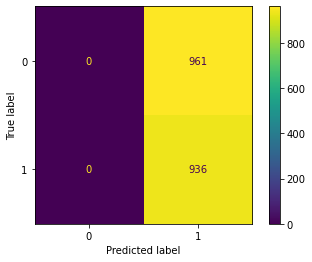

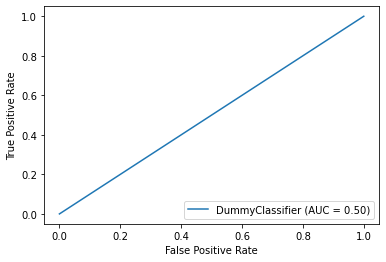

In [31]:
# Instantiate, fit, and run dummy model
dc = DummyClassifier(strategy="most_frequent", random_state=22)
dc.fit(X_train_scaled, y_train)
y_hat_train = dc.predict(X_train_scaled)
y_hat_test = dc.predict(X_test_scaled)
print(f'Train: {classification_report(y_train, y_hat_train, zero_division=0)}')
print(f'Test: {classification_report(y_test, y_hat_test, zero_division=0)}')

# Plot confusion matrix and ROC AUC for dummy model
plot_confusion_matrix(dc, X_test_scaled, y_test)
plot_roc_curve(dc, X_test_scaled, y_test);

DummyClassification model produces an accuracy ~50% as expected because it assigned the target variable according to the most_frequent label

Now that we have a baseline model, let us build a pipeline to streamline the rest of the modeling process

### Pipeline Construction

In [32]:
# Function with classifier input and pipeline output
def pipe_maker(classifier):
    pipe = imbPipeline([('scl', StandardScaler()), ('clf', classifier(random_state=22))])
    return pipe

In [33]:
# Function with Pipeline & Parameters input and gridsearch with optimum parameters output
def gridsearch_maker(pipeline, params):
    return GridSearchCV(estimator=pipeline,
                        param_grid=params,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)

In [34]:
# Function with pipline/gridsearch input and hyperparameters out for optimized accuracy
def best_acc(gridsearch):

    # Instantiate best_acc object
    best_acc = 0.0
    
    # Fit gridsearch to regularized data set
    gridsearch.fit(X_train, y_train)
    
    # Print best parameters
    print('Best paramaters are: %s' % gridsearch.best_params_)
    
    # Print best train accuracy_score
    print('Best training accuracy_score: %.3f' % gridsearch.best_score_)
    
    # Prediction on scaled test data
    y_hat_test = gridsearch.predict(X_test)
    
    # Print test data accuracy_score with best params
    print('Test accuracy_score with best parameters: %.3f ' % accuracy_score(y_test, y_hat_test))
    
    # Print confusion matrix and classification report
    print('Test: ', classification_report(y_test, y_hat_test, zero_division=0))
    
    # Plot confusion matrix and ROC AUC
    plot_confusion_matrix(gridsearch, X_test, y_test,cmap="plasma")
    plot_roc_curve(gridsearch, X_test, y_test);

Model away...

### Model 1: Logistic Regression Model

Best paramaters are: {'clf__dual': False, 'clf__max_iter': 1000, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Best training accuracy_score: 0.660
Test accuracy_score with best parameters: 0.665 
Test:                precision    recall  f1-score   support

           0       0.67      0.67      0.67       961
           1       0.66      0.66      0.66       936

    accuracy                           0.67      1897
   macro avg       0.67      0.67      0.67      1897
weighted avg       0.67      0.67      0.67      1897



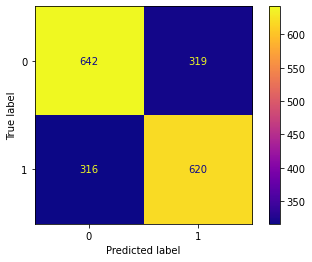

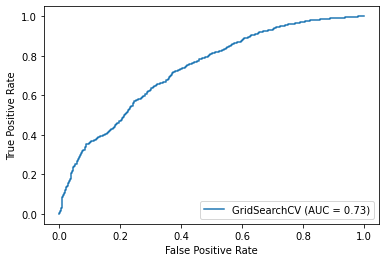

In [35]:
# Logistic Regression Model
pipe_dt = pipe_maker(LogisticRegression)
grid_params_dt = [{'clf__penalty': ['l1', 'l2', 'elasticnet'],
                  'clf__solver': ['liblinear', 'saga'],
                  'clf__dual': [True, False],
                  'clf__max_iter': [1000,10000]}]
gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)
best_acc(gs_dt)

LogisticRegression performed decently well with good fit and an accuracy of 67%. Now we will quantify the risk factors by calling the coefficients on the optimized parameter model

In [36]:
# Instantiate, fit, and run model with best parameters
# Print odds ratios and identify top 5 risk factors
lr = LogisticRegression(max_iter=1000, dual=False, penalty='l1', solver='saga', random_state=22)
lr.fit(X_train_scaled, y_train)
print(np.exp(lr.coef_))
COEF = np.exp(lr.coef_[0])
odds = pd.DataFrame(COEF, X.columns, 
        columns=['odds']).sort_values(by='odds', ascending=False)
odds.head()

[[1.08313385 0.94153568 1.13816414 1.5753479  0.97621566 0.89991844
  0.67578913 0.98481632 1.22732317 1.03983601 1.02018258 0.73459744
  0.94904997 1.19825874 1.02428965 0.71193096 0.69814602 0.94958382
  0.91784642 0.8227585 ]]


,odds
PF,1.575348
WEIGHT,1.227323
3P%,1.198259
%PFD,1.138164
MIN,1.083134


Here we see the 5 most impactful prior season risk factors for sustaining season-ending injuries are:
1. Personal Fouls per Game
2. Weight
3. 3 Point Field Goal Percentage
4. Percent of Team's Personal Fouls Drawn
5. Minutes per Season

Now let us compare the top 3 risk factors between those who sustained season ending injuries and those who did not

In [37]:
# Separate data into injured and noninjured cohorts
injured = df_con[(df_con['out_for_season']) == 1]
uninjured = df_con[(df_con['out_for_season']) == 0]

In [38]:
injured.describe()

,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,out_for_season,TEAM_ATL,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NJN,TEAM_NOH,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
count,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.00000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.0,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000
mean,26.768642,79.403442,223.026769,0.762906,0.759082,59.642447,-0.727151,0.536694,30.063098,29.57935,24.977820,10.968260,4.084704,8.934417,45.501912,0.821989,2.299618,28.108222,1.974379,2.586042,72.875526,1.112428,3.415105,4.528298,2.350096,1.470554,0.782600,0.521989,2.033078,22.363098,6.948375,0.164436,-0.016635,1570.315488,19.229637,19.652008,19.631549,18.424283,18.625430,19.623901,20.008987,20.602677,20.484895,20.560038,19.234417,19.060038,19.608987,20.438623,20.093690,20.630210,20.215296,19.622371,1.0,0.034417,0.032505,0.030593,0.040153,0.047801,0.028681,0.038241,0.043977,0.021033,0.034417,0.034417,0.024857,0.026769,0.034417,0.036329,0.026769,0.042065,0.049713,0.009560,0.009560,0.030593,0.038241,0.026769,0.032505,0.026769,0.038241,0.022945,0.036329,0.017208,0.021033,0.038241,0.024857
std,3.988250,3.650926,27.610163,0.425707,0.428050,19.855616,7.467559,0.061603,14.014697,12.64907,8.596248,6.160533,2.238362,4.707388,7.122513,0.748251,1.956901,15.995397,1.546047,1.891181,15.545546,0.895529,1.901013,2.648928,2.000923,0.813755,0.421254,0.517023,0.688657,10.679184,11.491260,0.988302,2.945861,804.920339,5.298795,5.765704,5.501391,14.168181,13.412419,10.270285,9.640073,14.938573,9.235571,10.026757,12.283501,6.580054,7.328212,17.074714,9.001189,6.673063,8.586874,5.900651,0.0,0.182472,0.177506,0.172376,0.196506,0.213550,0.167067,0.191961,0.205240,0.143630,0.182472,0.182472,0.155837,0.161561,0.182472,0.187286,0.161561,0.200930,0.217560,0.097401,0.097401,0.172376,0.191961,0.161561,0.177506,0.161561,0.191961,0.149870,0.187286,0.130172,0.143630,0.191961,0.155837
min,19.000000,69.000000,169.000000,0.000000,0.000000,1.000000,-73.900000,0.000000,0.000000,0.00000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,-9.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,77.000000,200.000000,1.000000,1.000000,47.000000,-4.100000,0.506500,20.000000,20.00000,18.700000,6.300000,2.400000,5.300000,41.500000,0.100000,0.200000,22.20

In [39]:
uninjured.describe()

,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,out_for_season,TEAM_ATL,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NJN,TEAM_NOH,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
count,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.0,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000
mean,26.989193,79.125198,221.354771,0.836321,0.806273,51.452557,-2.334713,0.512923,25.722720,25.729837,19.548419,7.816342,2.931550,6.556036,43.584528,0.616289,1.768345,24.861650,1.341697,1.789141,69.728888,0.872035,2.539088,3.408355,1.724802,1.106906,0.615156,0.389457,1.707090,16.394333,3.863732,0.112283,-0.390933,1163.764628,17.986162,18.068635,18.571455,17.145809,18.040116,17.027201,17.592225,20.495572,19.585899,19.906036,17.941908,18.143358,19.215156,19.936083,19.040775,22.195203,18.107222,17.896732,0.0,0.032683,0.022667,0.033737,0.032683,0.029520,0.035846,0.034265,0.030575,0.032420,0.031892,0.032947,0.033474,0.034265,0.033737,0.036373,0.034001,0.033210,0.030311,0.012915,0.016078,0.019504,0.033210,0.034265,0.030838,0.035055,0.031365,0.032683,0.031629,0.035846,0.034792,0.031892,0.035319
std,4.298221,3.538852,26.473395,0.370033,0.395270,25.131985,12.361189,0.101652,16.150331,14.812904,9.382916,5.576685,2.037336,4.319536,10.128393,0.683934,1.786689,17.077545,1.288938,1.607527,20.313972,0.792561,1.724426,2.385627,1.732757,0.763123,0.425387,0.424357,0.751201,10.252441,8.744228,1.082927,2.922872,852.852917,5.165719,6.412772,5.876221,15.523572,14.568888,10.414460,10.099245,15.506795,8.770777,9.636700,12.708207,8.231485,10.067040,18.073105,11.522312,9.157542,8.960086,6.201951,0.0,0.177829,0.148860,0.180576,0.177829,0.169282,0.185931,0.181932,0.172185,0.177135,0.175737,0.178521,0.179894,0.181932,0.180576,0.187242,0.181256,0.179209,0.171464,0.112923,0.125792,0.138308,0.179209,0.181932,0.172902,0.183944,0.174326,0.177829,0.175033,0.185931,0.183276,0.175737,0.184609
min,19.000000,65.000000,133.000000,0.000000,0.000000,1.000000,-150.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.800000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,77.000000,200.000000,1.000000,1.000000,31.000000,-6.500000,0.48

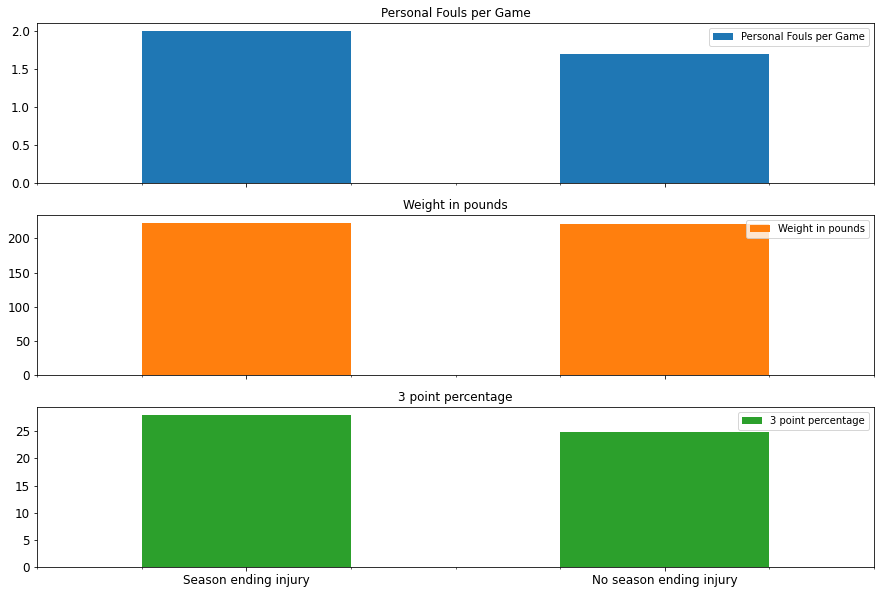

In [40]:
# Build chart comparing PF, weight, and 3P% between injury and non-injury cohorts
x=['Season ending injury','No season ending injury']
pf=[2.0,1.7]
weight=[223,221]
threepointper=[28.1,24.9]
r3 = pd.DataFrame({'Personal Fouls per Game':pf,'Weight in pounds':weight,'3 point percentage':threepointper}, index=x)
axes = r3.plot.bar(rot=0, subplots=True, figsize=(15,10),fontsize=12)
axes[1].legend(loc=1);

Here we can visualize the differences between the season ending injury cohort and the cohort that did sustain season ending injuries

Let us move on to more advance models

### Model 2: Random Forest Model

Best paramaters are: {'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'gini', 'clf__max_depth': 40}
Best training accuracy_score: 0.883
Test accuracy_score with best parameters: 0.895 
Test:                precision    recall  f1-score   support

           0       0.91      0.88      0.89       961
           1       0.88      0.91      0.90       936

    accuracy                           0.90      1897
   macro avg       0.90      0.90      0.90      1897
weighted avg       0.90      0.90      0.90      1897



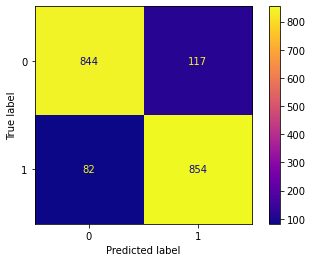

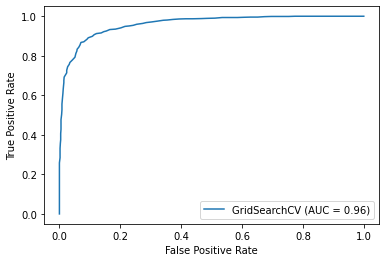

In [41]:
# Random Forest Model
pipe_dt = pipe_maker(RandomForestClassifier)
grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
                  'clf__max_depth': [40,50,60],
                  'clf__class_weight': ['balanced', 'balanced_subsample']}]
gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)
best_acc(gs_dt)

RandomForestClassifier performed better than LogisticRegression, achieving 90% accuracy. Let us see how XGBoost will perform

### Model 3: XGBoost Model

Best paramaters are: {'clf__booster': 'gbtree', 'clf__eta': 1, 'clf__max_depth': 6}
Best training accuracy_score: 0.891
Test accuracy_score with best parameters: 0.896 
Test:                precision    recall  f1-score   support

           0       0.90      0.89      0.90       961
           1       0.89      0.90      0.90       936

    accuracy                           0.90      1897
   macro avg       0.90      0.90      0.90      1897
weighted avg       0.90      0.90      0.90      1897



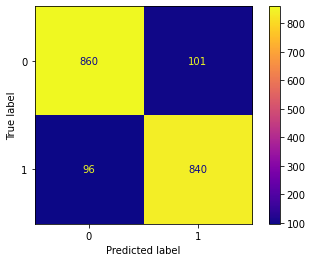

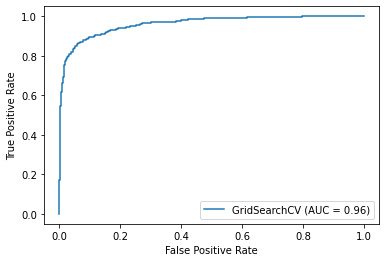

In [42]:
# XGBoost Model
pipe_dt = pipe_maker(XGBClassifier)
grid_params_dt = [{'clf__booster': ['gbtree', 'gblinear', 'gbdart'],
                  'clf__eta': [0,1],
                  'clf__max_depth': [4,5,6]}]
gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)
best_acc(gs_dt)

XGBClassifier also performed well, matching the performance of RandomForestClassifier with 90% accuracy. Let us see how an ensemble model combining the prior 3 models will perform

### Model 5: Combined Ensemble Model (Logistic Regression, Random Forest, XGBoost)

Train:               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2833
           1       0.97      0.99      0.98      2858

    accuracy                           0.98      5691
   macro avg       0.98      0.98      0.98      5691
weighted avg       0.98      0.98      0.98      5691

Test:               precision    recall  f1-score   support

           0       0.85      0.79      0.82       961
           1       0.80      0.85      0.83       936

    accuracy                           0.82      1897
   macro avg       0.82      0.82      0.82      1897
weighted avg       0.82      0.82      0.82      1897



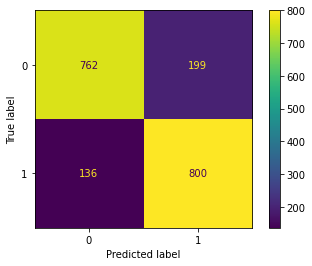

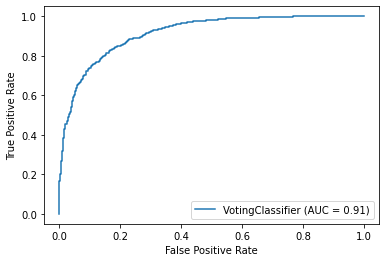

In [43]:
# Combined hypertuned prior models for ultimate ensemble
clf1 = LogisticRegression(max_iter=1000, dual=True, penalty='l2', solver='liblinear', random_state=22)
clf2 = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=50, random_state=22)
clf3 = XGBClassifier(booster='gbtree', eta=0, max_depth=4, random_state=22)

w_avg = VotingClassifier(estimators=[
    ('lr', clf1),
    ('rf', clf2),
    ('xgb', clf3)],
     voting='soft')
w_avg.fit(X_train_scaled, y_train) 
y_hat_train = w_avg.predict(X_train_scaled)
y_hat_test = w_avg.predict(X_test_scaled)
print(f'Train: {classification_report(y_train, y_hat_train)}')
print(f'Test: {classification_report(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(w_avg, X_test_scaled, y_test)
plot_roc_curve(w_avg, X_test_scaled, y_test);

VotingClassifier consisting of LogisticRegression, RandomForest, and XGBoost performed well 82% accuracy but was a bit overfit with the training set accuracy being 98%. Let us compare the models below

### Comparing Models

In [44]:
# Model comparison
LogReg = ['Logistic Regression', 0.67, 0.73, 0.66]
RanFor = ['Random Forest', 0.9, 0.96, 0.9]
XGBoost = ['XGBoost', 0.9, 0.96, 0.9]
Combined = ['Combined Models', 0.8, 0.88, 0.8]
all_models = pd.DataFrame(list([LogReg,RanFor,XGBoost,Combined]), 
                          columns=['Model','Accuracy','AUC', 'f1 score']).sort_values(['Accuracy'], ascending=False)
all_models

,Model,Accuracy,AUC,f1 score
1,Random Forest,0.90,0.96,0.90
2,XGBoost,0.90,0.96,0.90
3,Combined Models,0.80,0.88,0.80
0,Logistic Regression,0.67,0.73,0.66


Here we see that RandomForest and XGBoost tied for best model performance. Let us dig in to the particulars in the Results section

## Results

Both RandomForest and XGBoost achieved an accuracy of 90% with a ROC AUC of 96% and f1 score of 90%. This means that our model was very effective in predicting season ending injury in among NBA players

The 3 most impactful risk factors for season-ending injury were as follows:

1. Players were 1.57 times more likely to sustain a season-ending injury for every personal foul they committed per game.
2. Players were 1.23 times more likely to sustain a season-ending injury for every pound of weight they had.
3. Players were 1.2 times more likely to sustain a season-ending injury for every percent of 3 point shooting accuracy they demonstrated.

## Conclusions

It seems that players involved in more physical play (personal fouls per game), who weighed more (weight), and who shot 3 pointers well (3 point field goal percentage) were at high risk and require strategies to mitigate risks while minimizing impact on play.

## Recommendations

Based on the analysis it is recommended that players implement 3 targeted approaches to reduce risk:

1. Players averaging >2 personal fouls per game should be counseled on foul avoidance strategies focused on their specific predominant foul type (blocking foul, illegal screen, etc).
2. Players weighing > 223 pounds should be on an injury prevention training plan and closely monitored for signs of injury.
3. Players who have a 3 point shooting percentage >28% should be counseled on safe landing strategies when shooting 3 point shots.

## Future Considerations

The next steps to improve upon this analysis would be to perform a matched cohort study to address the target feature imbalance. Along with this, segmenting the analysis by specific injury (ACL, Achilles tendon, etc.) would allow for more focused risk reduction recommendations. Last, extrapolating the findings and recommendations to the weekend warrior would widen the utility of this work and likely reduce risk of injury among this highly passionate cohort.